<a href="https://colab.research.google.com/github/alexgirmag/Predicting-Emergency-Department-Mortality-Risk-Using-Machine-Learning-Algorithms/blob/main/XGB_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries and pre-prosessed data

## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

# Scikit-learn: Models & Multioutput
from xgboost import XGBClassifier
# Scikit-learn: Preprocessing & Composition
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Scikit-learn: Model Selection & Metrics
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.experimental import enable_halving_search_cv  # Required for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Imbalanced-learn: Pipeline & Sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

## Importing pre-prosessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path1 =  "/content/drive/MyDrive/X_train_2_8.xlsx"

In [ ]:
file_path2 =  "/content/drive/MyDrive/X_test_2_8.xlsx"

In [ ]:
file_path3 =  "/content/drive/MyDrive/y_train_2_8.xlsx"

In [ ]:
file_path4 =  "/content/drive/MyDrive/y_test_2_8.xlsx"

In [ ]:
X_train = pd.read_excel(file_path1)

In [ ]:
X_test = pd.read_excel(file_path2)

In [ ]:
y_train = pd.read_excel(file_path3)

In [ ]:
y_test = pd.read_excel(file_path4)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7063, 23)
(1766, 23)
(7063, 1)
(1766, 1)



# Modularize Evaluation and Plotting

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
import numpy as np

def evaluate_model_performance(y_true, y_pred, y_proba, model_name="Model"):
    """
    Evaluates a classification model and generates various plots.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model for display in plots and reports.
    """

    print(f"\n{'='*20} Evaluation for {model_name} {'='*20}")

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['alive (0)', 'Died (1)']))

    # 2. Confusion Matrix with Specificity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # 3. AUC-ROC Curve
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba)
    roc_auc_plot = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc_plot:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall/Sensitivity)')
    plt.title(f'{model_name} - Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Precision-Recall Curve with Optimal Threshold
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # Avoid division by zero

    # Find the optimal threshold (max F1-score)
    # Note: thresholds_pr has one less element than precision/recall, so we align indices
    optimal_idx = np.argmax(f1_scores[:-1]) # Exclude the last element of f1_scores for threshold alignment
    optimal_threshold = thresholds_pr[optimal_idx]
    optimal_precision = precision[optimal_idx]
    optimal_recall = recall[optimal_idx]

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.scatter(optimal_recall, optimal_precision, color='red', s=100,
                label=f'Optimal Point (Threshold = {optimal_threshold:.2f})\nPrecision = {optimal_precision:.2f}, Recall = {optimal_recall:.2f}')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title(f'{model_name} - Precision-Recall Curve with Optimal Threshold')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # 5. Classification Report and Confusion Matrix at Optimal Threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print(f"\nClassification Report at Optimal Threshold ({optimal_threshold:.2f}):")
    print(classification_report(y_true, y_pred_optimal, target_names=['Alive', 'Died']))

    cm_optimal = confusion_matrix(y_true, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
    specificity_optimal = tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) != 0 else 0
    print(f"Confusion Matrix at Optimal Threshold:\n{cm_optimal}")
    print(f"Specificity (True Negative Rate) at Optimal Threshold: {specificity_optimal:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f"{model_name} - Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
    plt.show()
    print(f"\n{'='*60}")

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

In [ ]:
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

# Train model Before Balancing

##Before Balancing And Tuning

**Training**

In [ ]:
model_1 = XGBClassifier(random_state=123)

In [ ]:
model_1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

[0]	validation_0-logloss:0.23738	validation_1-logloss:0.24444
[10]	validation_0-logloss:0.17328	validation_1-logloss:0.20805
[20]	validation_0-logloss:0.15557	validation_1-logloss:0.20869
[30]	validation_0-logloss:0.14308	validation_1-logloss:0.21026
[40]	validation_0-logloss:0.13417	validation_1-logloss:0.21300
[50]	validation_0-logloss:0.12528	validation_1-logloss:0.21623
[60]	validation_0-logloss:0.11801	validation_1-logloss:0.22137
[70]	validation_0-logloss:0.11254	validation_1-logloss:0.22358
[80]	validation_0-logloss:0.10523	validation_1-logloss:0.22677
[90]	validation_0-logloss:0.10125	validation_1-logloss:0.23106
[99]	validation_0-logloss:0.09600	validation_1-logloss:0.23405


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

**Prediction**

In [ ]:

y_pred1 = model_1.predict(X_test)
y_proba1 = model_1.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_1 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.99      0.97      1581
    Died (1)       0.90      0.52      0.66       185

    accuracy                           0.94      1766
   macro avg       0.92      0.76      0.82      1766
weighted avg       0.94      0.94      0.94      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9930


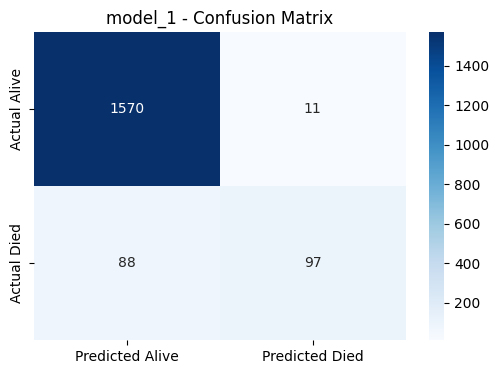


ROC-AUC Score: 0.7914


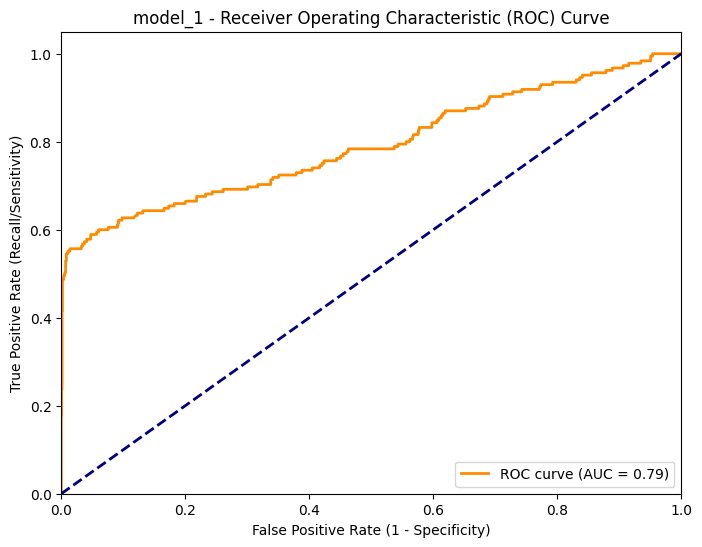

PR-AUC Score: 0.6417


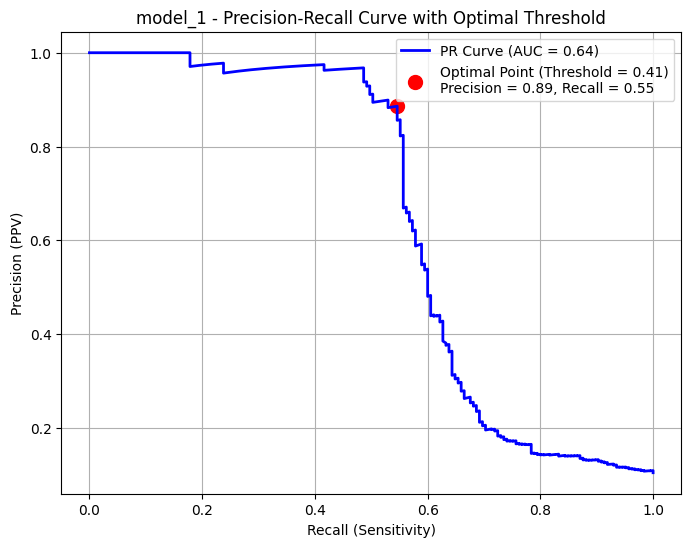


Classification Report at Optimal Threshold (0.41):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.89      0.55      0.68       185

    accuracy                           0.95      1766
   macro avg       0.92      0.77      0.82      1766
weighted avg       0.94      0.95      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1568   13]
 [  84  101]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9918


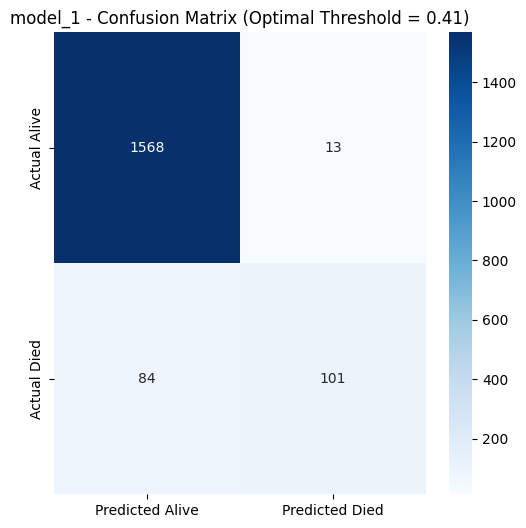

In [ ]:
evaluate_model_performance(y_test, y_pred1, y_proba1, model_name="model_1")

## Hyperparameter Tuning: RandomizedSearchCV

**Training**

In [ ]:

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': range(3, 10),
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': [x/10 for x in range(6, 11)],
    'colsample_bytree': [x/10 for x in range(6, 11)],
    'reg_alpha': [0, 0.1, 0.5, 1, 5],
    'reg_lambda': [0.1, 0.5, 1, 5, 10],
    'gamma': [x/10 for x in range(0, 5)],
    'min_child_weight': [1, 3, 5, 7]
}

In [ ]:

xgb_rs = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=param_dist,
    n_iter=100,
    scoring=f1_scorer,
    cv=cv,
    verbose=3,
    n_jobs=-1,
    random_state=123
)

In [ ]:
xgb_rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gro...
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': range(3, 10),
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 5],
                                        'reg_lambda': [0.1, 0.5, 1, 5, 10],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=123,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=3)

In [ ]:

print("Best parameters found: ", xgb_rs.best_params_)
print("Best F1 score: ", xgb_rs.best_score_)


Best parameters found:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best F1 score:  0.6853485152972847


In [ ]:

best_xgb_rs = xgb_rs.best_estimator_
best_xgb_rs.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

**Prediction**

In [ ]:

y_pred2 = best_xgb_rs.predict(X_test)
y_proba2 = best_xgb_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_2 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.99      0.97      1581
    Died (1)       0.90      0.51      0.66       185

    accuracy                           0.94      1766
   macro avg       0.93      0.75      0.81      1766
weighted avg       0.94      0.94      0.94      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9937


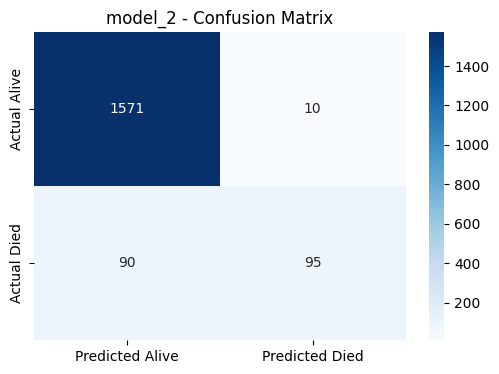


ROC-AUC Score: 0.8028


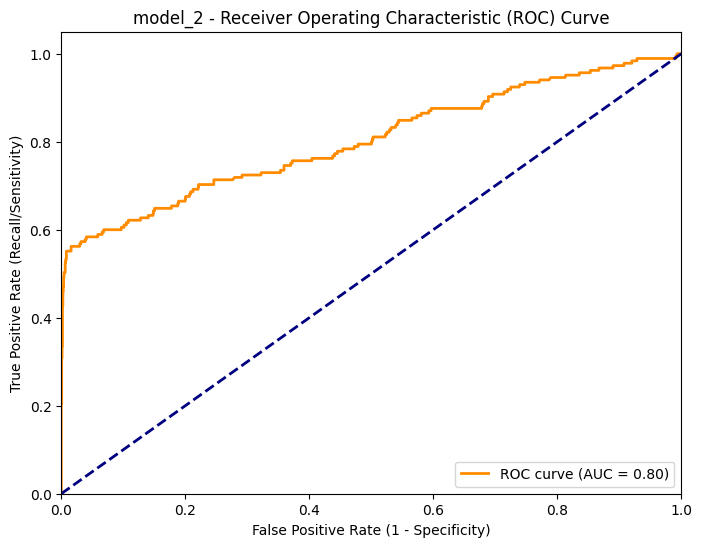

PR-AUC Score: 0.6454


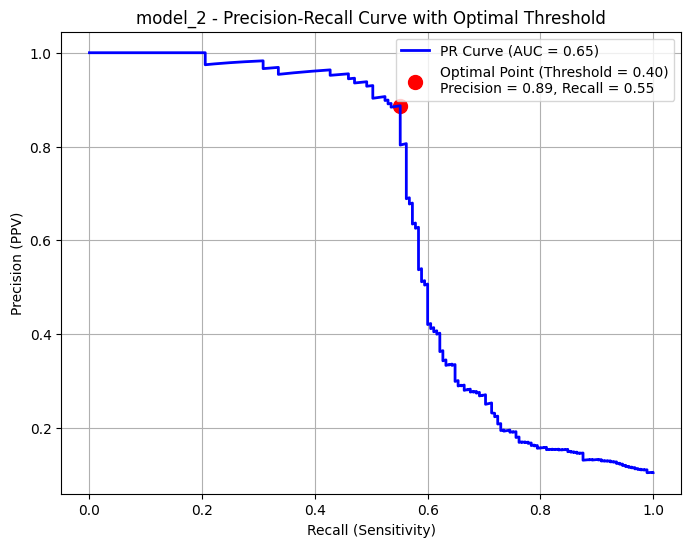


Classification Report at Optimal Threshold (0.40):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.89      0.55      0.68       185

    accuracy                           0.95      1766
   macro avg       0.92      0.77      0.83      1766
weighted avg       0.94      0.95      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1568   13]
 [  83  102]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9918


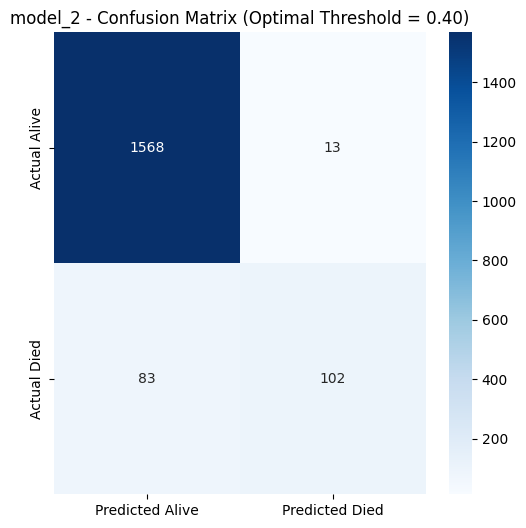

In [ ]:
evaluate_model_performance(y_test, y_pred2, y_proba2, model_name="model_2")

## Hyperparameter Tuning: Grid Search (GS)

**Training**

In [ ]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'gamma': [0, 0.1]
}

In [ ]:
# Grid Search
xgb_gs = GridSearchCV(
    estimator=model_1,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

In [ ]:
# Fit Grid Search
xgb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'gamma': [0, 0.1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [5, 6],
                         'n_estimators': [100, 200], 'reg_alpha': [0, 0.1],
                         'subsample': [0.8, 0.9]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
             verbose=1)

In [ ]:
# Results
print("Best parameters found: ", xgb_gs.best_params_)
print("Best F1 score: ", xgb_gs.best_score_)

Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}
Best F1 score:  0.680964271544629


In [ ]:
# Train final model with best params
best_xgb_gs = xgb_gs.best_estimator_
best_xgb_gs.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

**Prediction**

In [ ]:
# --- Classification Evaluation ---
y_pred3 = best_xgb_gs.predict(X_test)
y_proba3 = best_xgb_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_3 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.99      0.97      1581
    Died (1)       0.91      0.52      0.66       185

    accuracy                           0.94      1766
   macro avg       0.93      0.76      0.82      1766
weighted avg       0.94      0.94      0.94      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9943


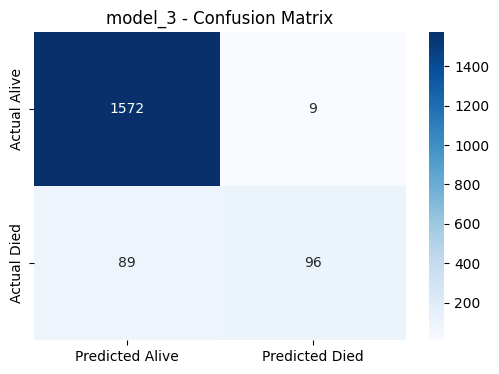


ROC-AUC Score: 0.7982


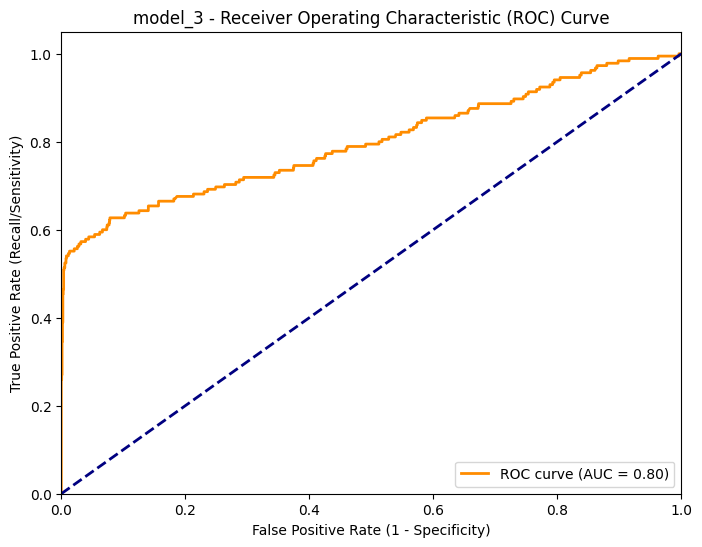

PR-AUC Score: 0.6471


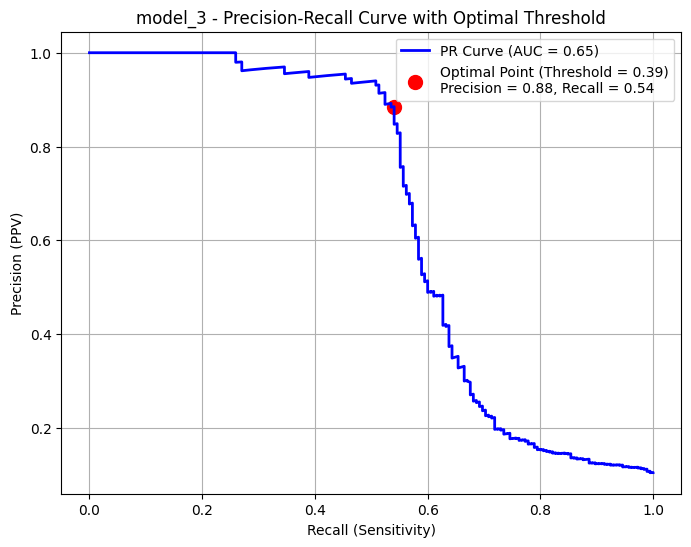


Classification Report at Optimal Threshold (0.39):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.88      0.54      0.67       185

    accuracy                           0.94      1766
   macro avg       0.92      0.77      0.82      1766
weighted avg       0.94      0.94      0.94      1766

Confusion Matrix at Optimal Threshold:
[[1568   13]
 [  85  100]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9918


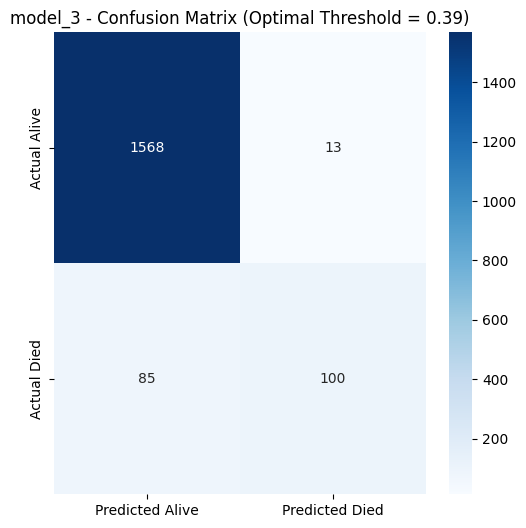

In [ ]:
evaluate_model_performance(y_test, y_pred3, y_proba3, model_name="model_3")

# Train the model after Balancing using SMOTE

## SMOTE Only

**Training**

In [ ]:

xgb_os = make_pipeline(
    SMOTE(random_state=123),
    model_1
)

In [ ]:

xgb_os.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_os_pred1 = xgb_os.predict(X_test)
y_os_proba1 = xgb_os.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_4 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.93      0.94      1581
    Died (1)       0.47      0.55      0.51       185

    accuracy                           0.89      1766
   macro avg       0.71      0.74      0.72      1766
weighted avg       0.90      0.89      0.89      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9292


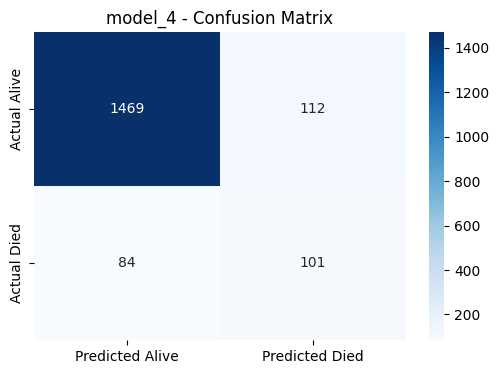


ROC-AUC Score: 0.8003


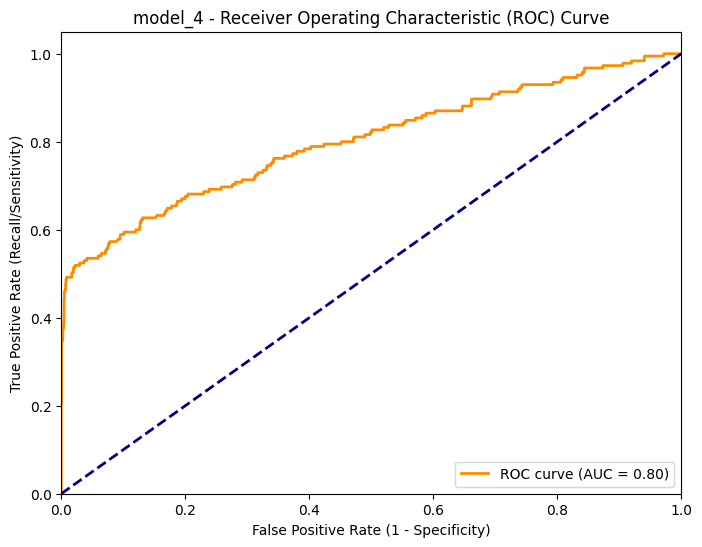

PR-AUC Score: 0.6143


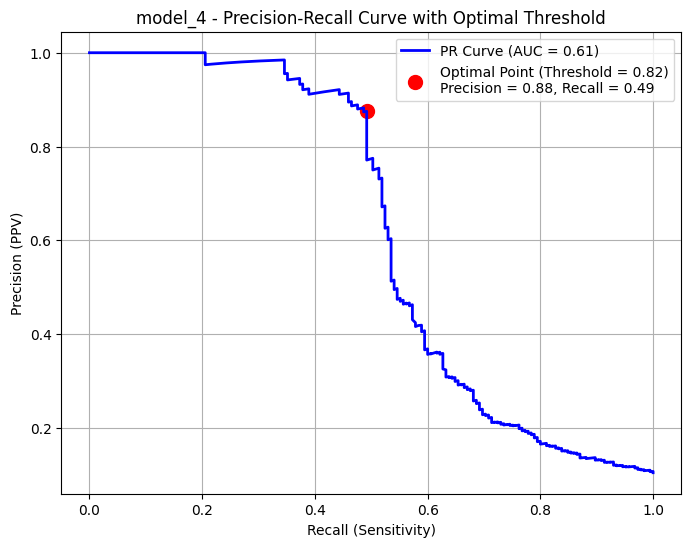


Classification Report at Optimal Threshold (0.82):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.97      1581
        Died       0.88      0.49      0.63       185

    accuracy                           0.94      1766
   macro avg       0.91      0.74      0.80      1766
weighted avg       0.94      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1568   13]
 [  94   91]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9918


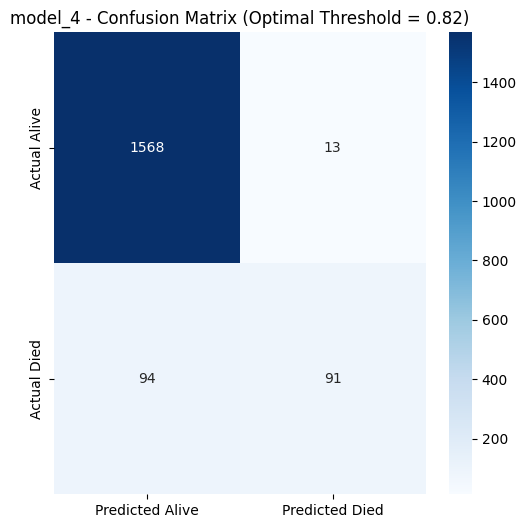

In [ ]:
evaluate_model_performance(y_test, y_os_pred1, y_os_proba1, model_name="model_4")

## SMOTE + RandomizedSearchCV

**Training**

In [ ]:

param_dist = {
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 5, 6, 8],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbclassifier__reg_alpha': [0, 0.5, 1],
    'xgbclassifier__reg_lambda': [0.5, 1, 2],
    'xgbclassifier__gamma': [0, 0.1, 0.3],
}

In [ ]:

xgb_os_rs = RandomizedSearchCV(
    estimator=xgb_os,
    param_distributions=param_dist,
    scoring=f1_scorer,
    n_iter=100,
    cv=cv,
    verbose=2,
    random_state=123,
    n_jobs=1
)

In [ ]:

xgb_os_rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=2, xgbclassifier__subsample=0.8; total time=   0.7s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=2, xgbclassifier__subsample=0.8; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=2, xgbclassifier__subsample=0.8; total time=   0.3s
[CV] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.1, xgbclassifier_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_m...
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.05,
                                                                         0.1,
                                                                         0.2],
                                        'xgbclassifier__max_depth': [3, 5, 6,
                                                                     8],
                                        'xgbclassifier__n_estimators': [100,
                                                                        200,
                                                                        300],
                                        'xgbclassifier__reg_alpha': [0, 0.5, 1],
                                        'xgbclassifier__reg_lambda': [0.5, 1,
                                                                      2],
                                        'xgbclassifier__subsample': [0.6, 0.8,
                                                                     1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=2)

In [ ]:

print("\nBest Params:", xgb_os_rs.best_params_)
print("Best F1 Score (CV):", xgb_os_rs.best_score_)


Best Params: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__reg_lambda': 0.5, 'xgbclassifier__reg_alpha': 1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.6}
Best F1 Score (CV): 0.5871404710003366


In [ ]:
best_xgb_os_rs = xgb_os_rs.best_estimator_
best_xgb_os_rs.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_os_pred2 = best_xgb_os_rs.predict(X_test)
y_os_proba2 = best_xgb_os_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_5 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.95      0.95      1581
    Died (1)       0.56      0.55      0.55       185

    accuracy                           0.91      1766
   macro avg       0.76      0.75      0.75      1766
weighted avg       0.91      0.91      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9507


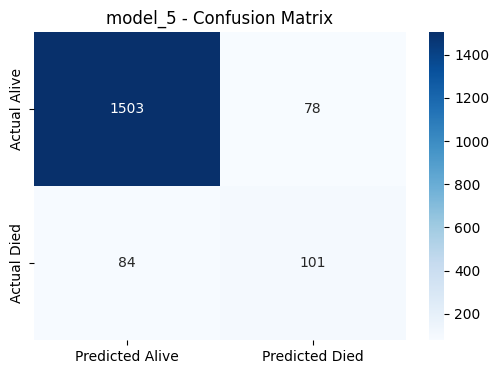


ROC-AUC Score: 0.8036


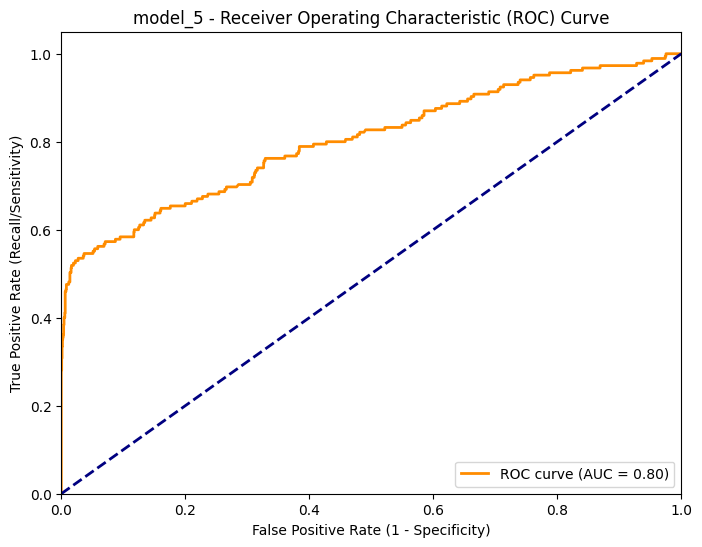

PR-AUC Score: 0.6168


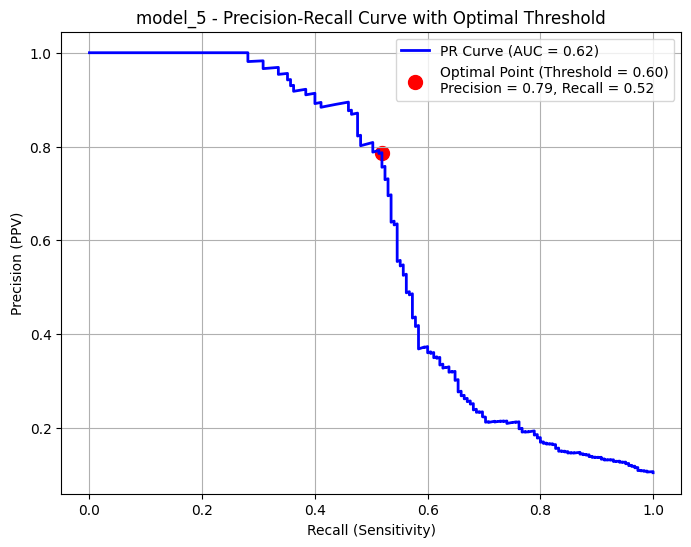


Classification Report at Optimal Threshold (0.60):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.96      1581
        Died       0.79      0.52      0.63       185

    accuracy                           0.93      1766
   macro avg       0.87      0.75      0.79      1766
weighted avg       0.93      0.93      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1555   26]
 [  89   96]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9836


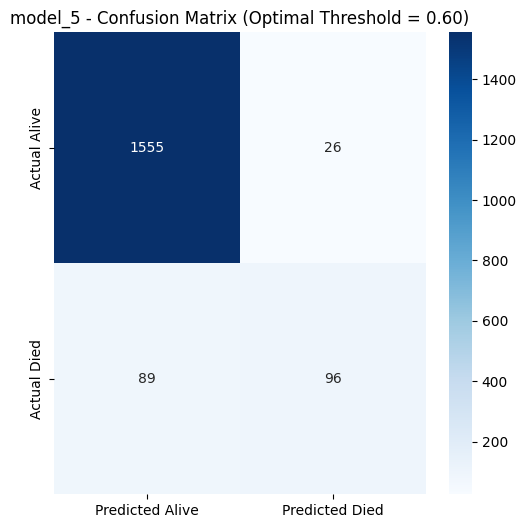

In [ ]:
evaluate_model_performance(y_test, y_os_pred2, y_os_proba2, model_name="model_5")

## SMOTE + GridSearchCV

In [ ]:
param_grid = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__max_depth': [3, 5, 6],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0],
    'xgbclassifier__reg_alpha': [0, 0.5, 1],
    'xgbclassifier__reg_lambda': [1, 5],
    'xgbclassifier__gamma': [0, 0.1]
}

In [ ]:
xgb_os_gs = GridSearchCV(
    estimator=xgb_os,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=1,
    verbose=2
)

In [ ]:

xgb_os_gs.fit(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=1, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=1, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=1, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=...
                         'xgbclassifier__gamma': [0, 0.1],
                         'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
                         'xgbclassifier__max_depth': [3, 5, 6],
                         'xgbclassifier__n_estimators': [100, 200],
                         'xgbclassifier__reg_alpha': [0, 0.5, 1],
                         'xgbclassifier__reg_lambda': [1, 5],
                         'xgbclassifier__subsample': [0.8, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
             verbose=2)

In [ ]:

print("\nBest Params:", xgb_os_gs.best_params_)
print("Best CV F1 Score:", xgb_os_gs.best_score_)


Best Params: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__reg_alpha': 0.5, 'xgbclassifier__reg_lambda': 1, 'xgbclassifier__subsample': 1.0}
Best CV F1 Score: 0.5748073862914157


In [ ]:
best_xgb_os_gs = xgb_os_gs.best_estimator_
best_xgb_os_gs.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_os_pred3 = best_xgb_os_gs.predict(X_test)
y_os_proba3 = best_xgb_os_gs.predict_proba(X_test)[:, 1]


**Evaluation**


==================== Evaluation for model_6 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.95      0.95      1581
    Died (1)       0.56      0.58      0.57       185

    accuracy                           0.91      1766
   macro avg       0.75      0.76      0.76      1766
weighted avg       0.91      0.91      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9462


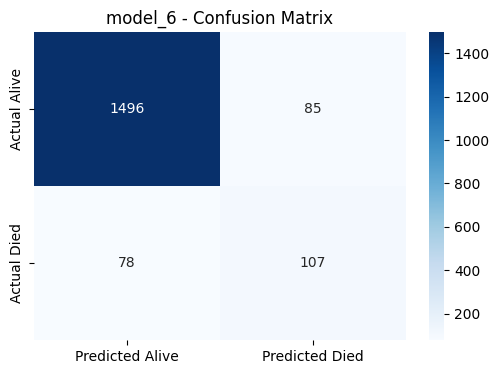


ROC-AUC Score: 0.8003


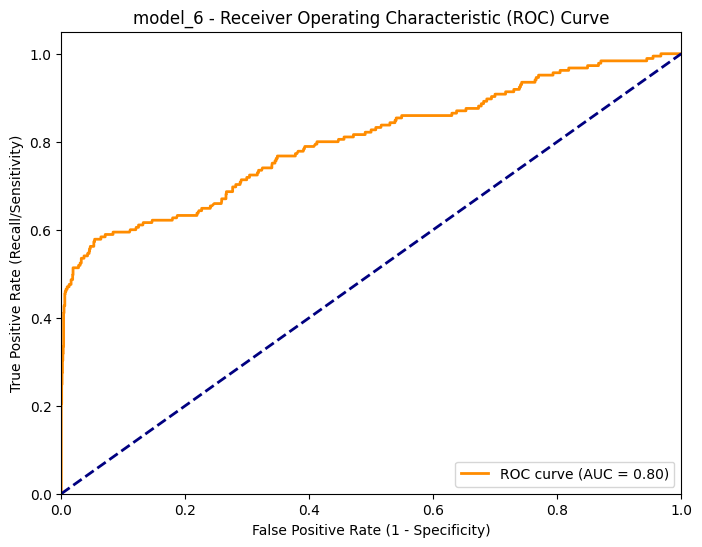

PR-AUC Score: 0.6097


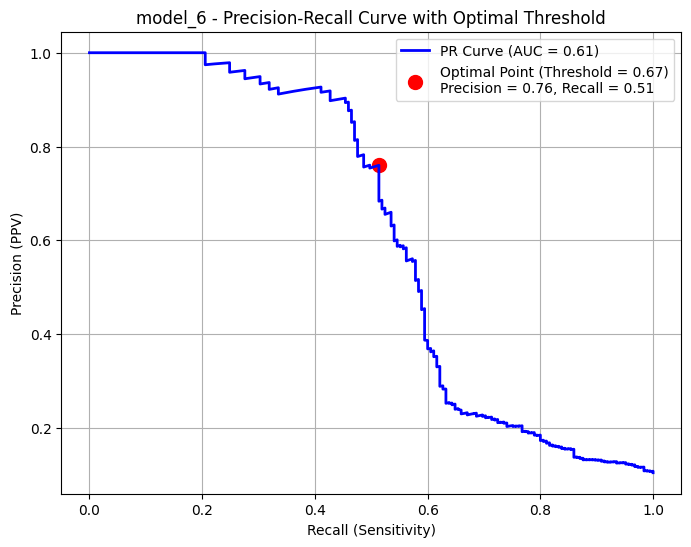


Classification Report at Optimal Threshold (0.67):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.96      1581
        Died       0.76      0.51      0.61       185

    accuracy                           0.93      1766
   macro avg       0.85      0.75      0.79      1766
weighted avg       0.93      0.93      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1551   30]
 [  90   95]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9810


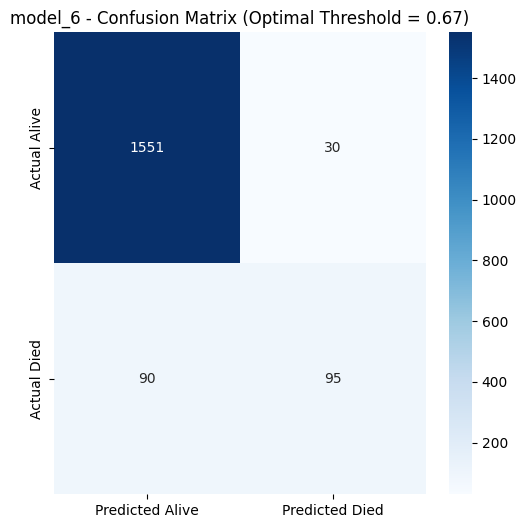

In [ ]:
evaluate_model_performance(y_test, y_os_pred3, y_os_proba3, model_name="model_6")

# Train the model after Balancing using Undersampling.

##UnderSampler Only

**Training**

In [ ]:

xgb_us = make_pipeline(
    RandomUnderSampler(random_state=123),
    model_1
)

In [ ]:
xgb_us.fit(X_train, y_train),


(Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                 ('xgbclassifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=None, max_leaves=None,
                                min_child

**Prediction**

In [ ]:

y_us_pred1 = xgb_us.predict(X_test)
y_us_proba1 = xgb_us.predict_proba(X_test)[:, 1]


**Evaluation**


==================== Evaluation for model_7 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.96      0.82      0.88      1581
    Died (1)       0.30      0.68      0.42       185

    accuracy                           0.80      1766
   macro avg       0.63      0.75      0.65      1766
weighted avg       0.89      0.80      0.83      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8191


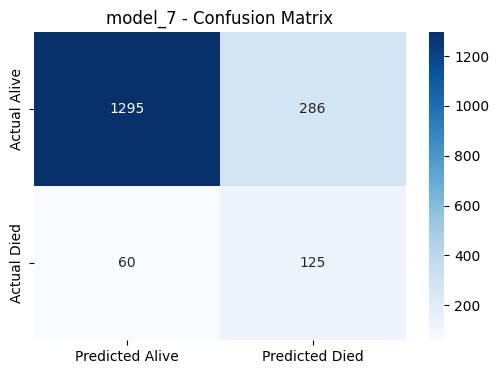


ROC-AUC Score: 0.7984


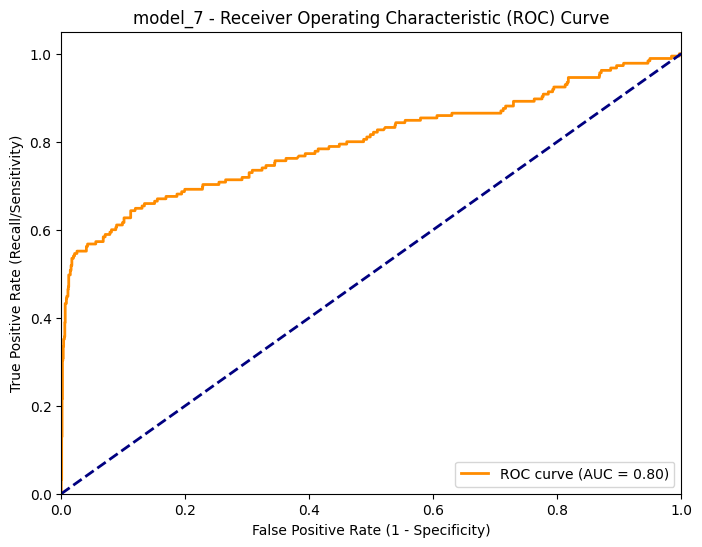

PR-AUC Score: 0.6067


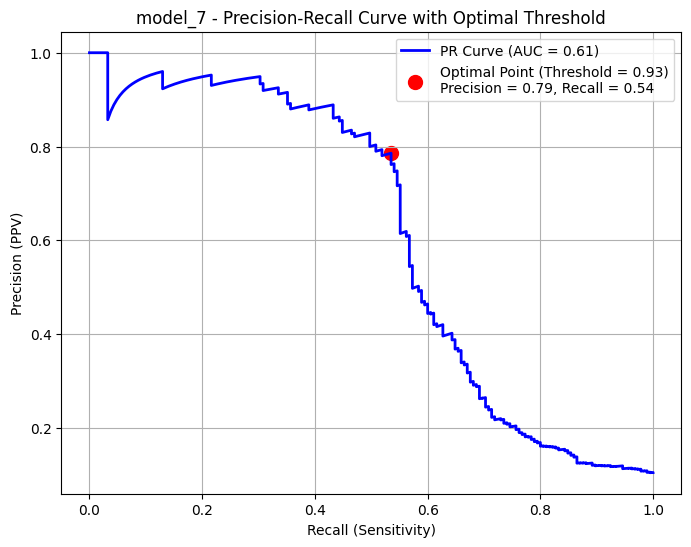


Classification Report at Optimal Threshold (0.93):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.96      1581
        Died       0.79      0.54      0.64       185

    accuracy                           0.94      1766
   macro avg       0.87      0.76      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1554   27]
 [  86   99]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9829


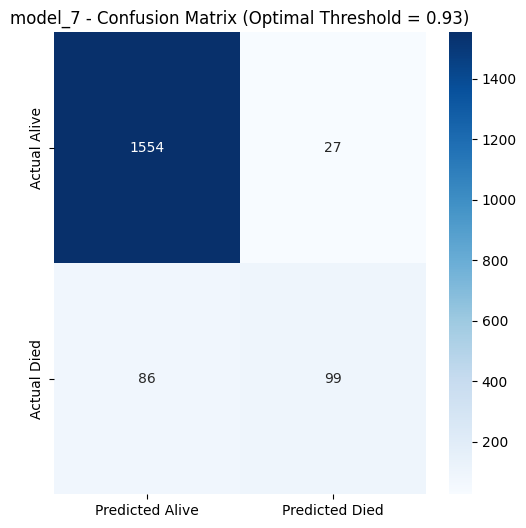

In [ ]:
evaluate_model_performance(y_test, y_us_pred1, y_us_proba1, model_name="model_7")

## UnderSampler + RandomizedSearchCV (RS)

**Training**

In [ ]:

xgb_us_rs = RandomizedSearchCV(
    estimator=xgb_us,
    param_distributions=param_dist,
    scoring=f1_scorer,
    n_iter=30,
    cv=cv,
    verbose=2,
    n_jobs=1,
    random_state=123
)

In [ ]:

xgb_us_rs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=2, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=2, xgbclassifier__subsample=0.8; total time=   0.2s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=2, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('randomundersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enabl...
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.05,
                                                                         0.1,
                                                                         0.2],
                                        'xgbclassifier__max_depth': [3, 5, 6,
                                                                     8],
                                        'xgbclassifier__n_estimators': [100,
                                                                        200,
                                                                        300],
                                        'xgbclassifier__reg_alpha': [0, 0.5, 1],
                                        'xgbclassifier__reg_lambda': [0.5, 1,
                                                                      2],
                                        'xgbclassifier__subsample': [0.6, 0.8,
                                                                     1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=2)

In [ ]:

print("\nBest Params:", xgb_us_rs.best_params_)
print("Best F1 Score (CV):", xgb_us_rs.best_score_)


Best Params: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__reg_lambda': 2, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.8}
Best F1 Score (CV): 0.5799792315263295


In [ ]:

best_xgb_us_rs = xgb_us_rs.best_estimator_
best_xgb_us_rs.fit(X_train, y_train)


Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_us_pred2 = best_xgb_us_rs.predict(X_test)
y_us_proba2 = best_xgb_us_rs.predict_proba(X_test)[:, 1]


**Evaluation**


==================== Evaluation for model_8 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.94      0.95      1581
    Died (1)       0.53      0.59      0.56       185

    accuracy                           0.90      1766
   macro avg       0.74      0.77      0.75      1766
weighted avg       0.91      0.90      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9393


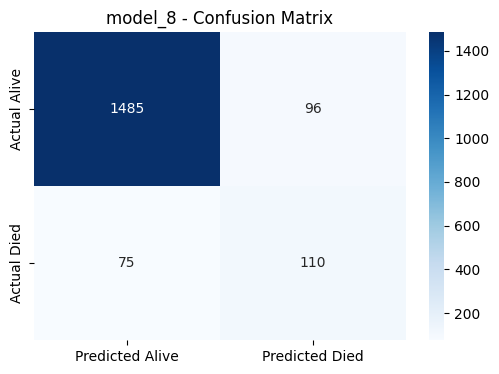


ROC-AUC Score: 0.7719


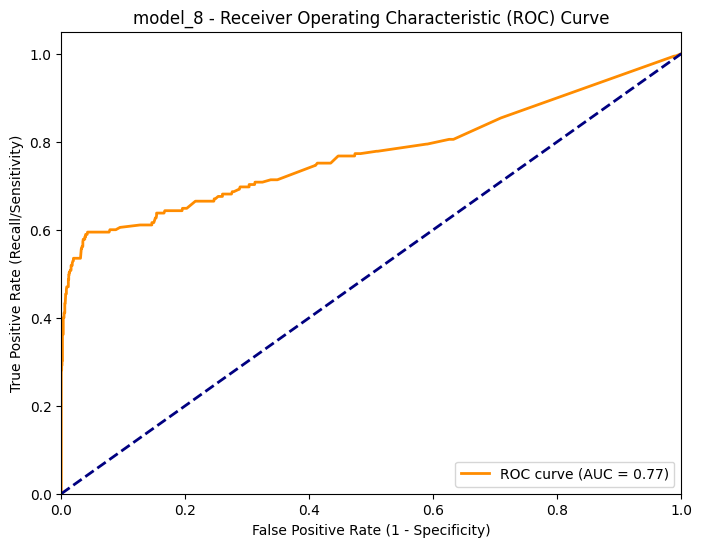

PR-AUC Score: 0.6200


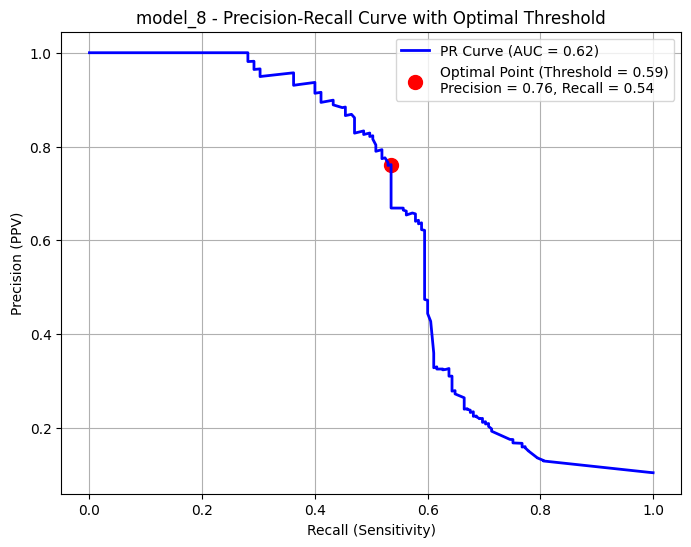


Classification Report at Optimal Threshold (0.59):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.96      1581
        Died       0.76      0.54      0.63       185

    accuracy                           0.93      1766
   macro avg       0.85      0.76      0.80      1766
weighted avg       0.93      0.93      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1550   31]
 [  86   99]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9804


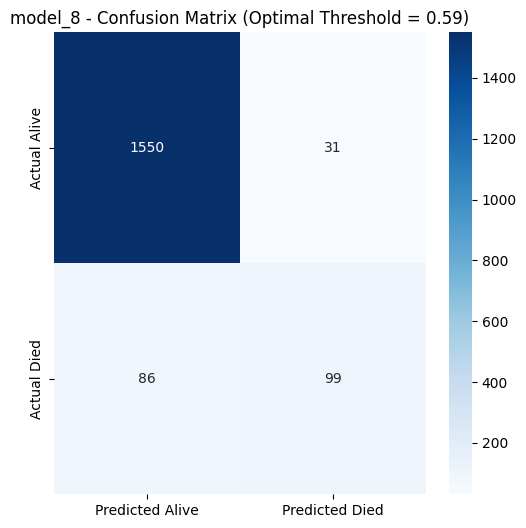

In [ ]:
evaluate_model_performance(y_test, y_us_pred2, y_us_proba2, model_name="model_8")

## UnderSampler + GridSearchCV (GS)

**Taining**

In [ ]:
param_grid = {
    'xgbclassifier__n_estimators': [200, 300],
    'xgbclassifier__max_depth': [5, 6],
    'xgbclassifier__learning_rate': [0.03, 0.05],
    'xgbclassifier__subsample': [0.7, 0.8],
    'xgbclassifier__colsample_bytree': [0.7, 0.8],
    'xgbclassifier__gamma': [0.1, 0.2],
    'xgbclassifier__reg_alpha': [0.5, 1],
    'xgbclassifier__reg_lambda': [2.0, 2.5],
    'xgbclassifier__scale_pos_weight': [5, 6]
}

In [ ]:

xgb_us_gs = GridSearchCV(
    estimator=xgb_us,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    verbose=2,
    n_jobs=1
)


In [ ]:
xgb_us_gs.fit(X_train, y_train)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
[CV] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.03, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200, xgbclassifier__reg_alpha=0.5, xgbclassifier__reg_lambda=2.0, xgbclassifier__scale_pos_weight=5, xgbclassifier__subsample=0.7; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.03, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200, xgbclassifier__reg_alpha=0.5, xgbclassifier__reg_lambda=2.0, xgbclassifier__scale_pos_weight=5, xgbclassifier__subsample=0.7; total time=   0.1s
[CV] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.03, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200, xgbclassifier__reg_alpha=0.5, xgbclassifier__reg_lambda=2.0, xgbclassifier__scale_pos_weight=5, xgbclassifier__subsample=0.7; total time=   0.

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_cate...
                         'xgbclassifier__learning_rate': [0.03, 0.05],
                         'xgbclassifier__max_depth': [5, 6],
                         'xgbclassifier__n_estimators': [200, 300],
                         'xgbclassifier__reg_alpha': [0.5, 1],
                         'xgbclassifier__reg_lambda': [2.0, 2.5],
                         'xgbclassifier__scale_pos_weight': [5, 6],
                         'xgbclassifier__subsample': [0.7, 0.8]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
             verbose=2)

In [ ]:

print("\nBest Params:", xgb_us_gs.best_params_)
print("Best CV F1 Score:", xgb_us_gs.best_score_)


Best Params: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.2, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__reg_alpha': 0.5, 'xgbclassifier__reg_lambda': 2.0, 'xgbclassifier__scale_pos_weight': 5, 'xgbclassifier__subsample': 0.8}
Best CV F1 Score: 0.2697702298969373


In [ ]:
best_xgb_us_gs = xgb_us_gs.best_estimator_
best_xgb_us_gs.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_us_pred3 = best_xgb_us_gs.predict(X_test)
y_us_proba3 = best_xgb_us_gs.predict_proba(X_test)[:, 1]


**Evaluation**


==================== Evaluation for model_9 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.96      0.45      0.61      1581
    Died (1)       0.15      0.83      0.25       185

    accuracy                           0.49      1766
   macro avg       0.55      0.64      0.43      1766
weighted avg       0.87      0.49      0.57      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.4478


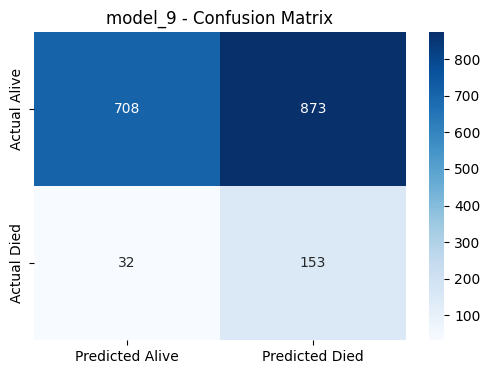


ROC-AUC Score: 0.8080


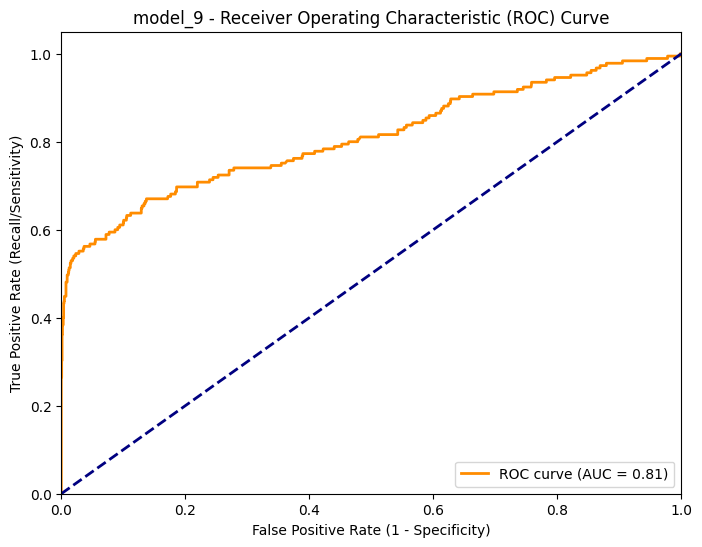

PR-AUC Score: 0.6363


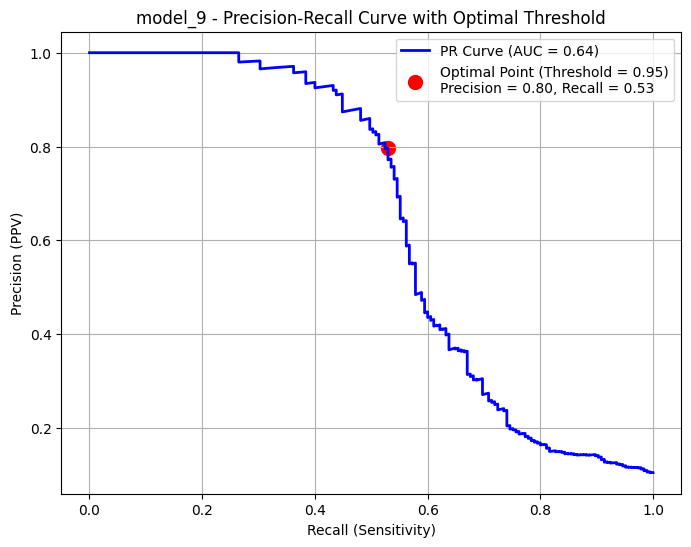


Classification Report at Optimal Threshold (0.95):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.97      1581
        Died       0.80      0.53      0.64       185

    accuracy                           0.94      1766
   macro avg       0.87      0.76      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1556   25]
 [  87   98]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9842


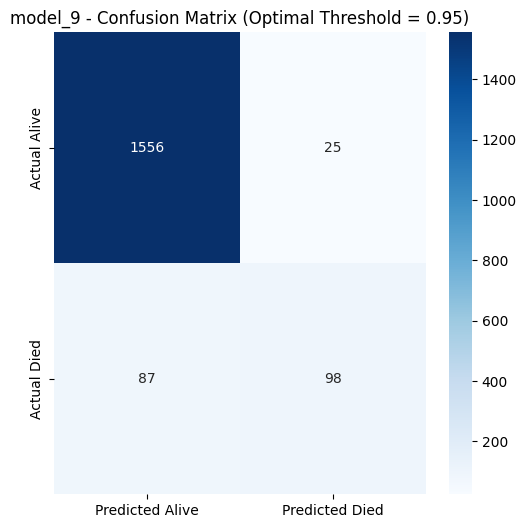

In [ ]:
evaluate_model_performance(y_test, y_us_pred3, y_us_proba3, model_name="model_9")

# Train the model after Balancing using HYBRID RESAMPLING

##Hybrid Only

**Training**

In [ ]:
xgb_hy = make_pipeline(
    SMOTE(random_state=123),
    RandomUnderSampler(random_state=123),
    model_1,
)

In [ ]:

xgb_hy.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None,...ne,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_hy_pred1= xgb_hy.predict(X_test)
y_hy_proba1 = xgb_hy.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_10 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.96      0.82      0.88      1581
    Died (1)       0.30      0.68      0.42       185

    accuracy                           0.80      1766
   macro avg       0.63      0.75      0.65      1766
weighted avg       0.89      0.80      0.83      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.8191


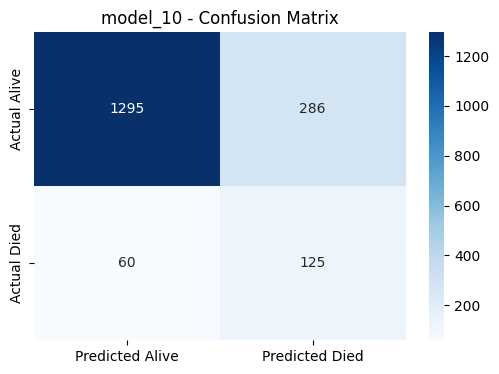


ROC-AUC Score: 0.7984


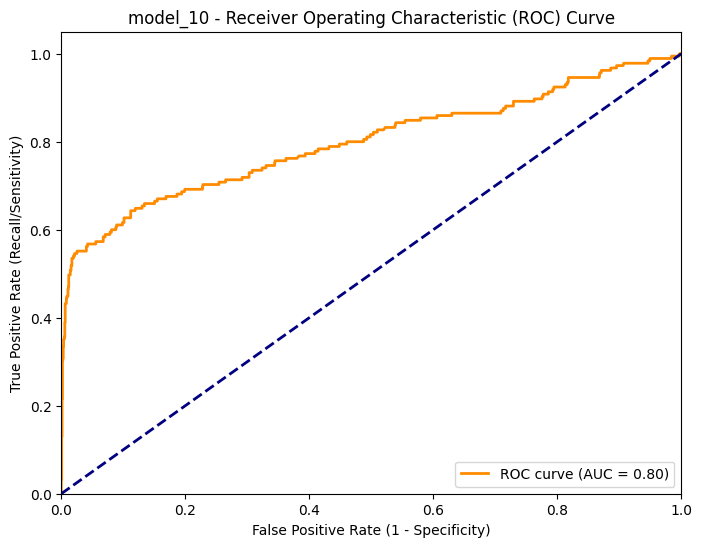

PR-AUC Score: 0.6067


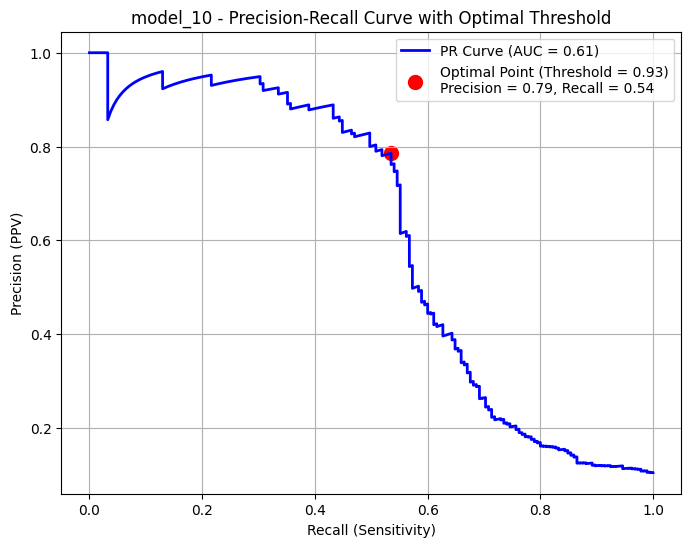


Classification Report at Optimal Threshold (0.93):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.96      1581
        Died       0.79      0.54      0.64       185

    accuracy                           0.94      1766
   macro avg       0.87      0.76      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1554   27]
 [  86   99]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9829


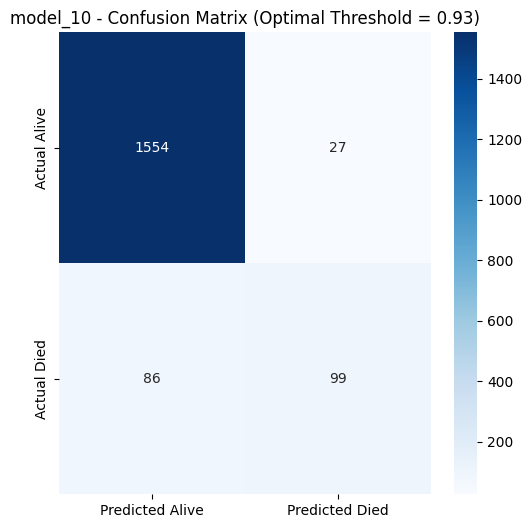

In [ ]:
evaluate_model_performance(y_test, y_us_pred1, y_us_proba1, model_name="model_10")

## Hybrid + RS

**Training**

In [ ]:
param_dist = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__max_depth': [5, 9],
    'xgbclassifier__learning_rate': np.logspace(-2, -1, 5),
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0],
    'xgbclassifier__reg_alpha': np.logspace(-1, 1, 5),
    'xgbclassifier__reg_lambda': np.logspace(0, 1, 5),
    'xgbclassifier__gamma': [0, 0.1, 0.3],
    'smote__sampling_strategy': [0.5, 0.75]
}

In [ ]:

xgb_hy_rs = RandomizedSearchCV(
    estimator=xgb_hy,
    param_distributions=param_dist,
    n_iter=50,
    scoring=f1_scorer,
    cv=cv,
    verbose=2,
    n_jobs=1,
    random_state=123
)

In [ ]:
xgb_hy_rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END smote__sampling_strategy=0.75, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.01778279410038923, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=1.0, xgbclassifier__subsample=0.8; total time=   0.2s
[CV] END smote__sampling_strategy=0.75, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.01778279410038923, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=1.0, xgbclassifier__subsample=0.8; total time=   0.3s
[CV] END smote__sampling_strategy=0.75, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0.1, xgbclassifier__learning_rate=0.01778279410038923, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=1.0, xgbclassifier__

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('randomundersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None...
                                        'xgbclassifier__max_depth': [5, 9],
                                        'xgbclassifier__n_estimators': [100,
                                                                        200],
                                        'xgbclassifier__reg_alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ]),
                                        'xgbclassifier__reg_lambda': array([ 1.        ,  1.77827941,  3.16227766,  5.62341325, 10.        ]),
                                        'xgbclassifier__subsample': [0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=2)

In [ ]:

print("\nBest Params:", xgb_hy_rs.best_params_)
print("Best CV F1 Score:", xgb_hy_rs.best_score_)


Best Params: {'xgbclassifier__subsample': 0.8, 'xgbclassifier__reg_lambda': np.float64(1.7782794100389228), 'xgbclassifier__reg_alpha': np.float64(1.0), 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 9, 'xgbclassifier__learning_rate': np.float64(0.01778279410038923), 'xgbclassifier__gamma': 0.3, 'xgbclassifier__colsample_bytree': 0.8, 'smote__sampling_strategy': 0.75}
Best CV F1 Score: 0.5775189132868671


In [ ]:
best_xgb_hy_rs = xgb_hy_rs.best_estimator_
best_xgb_hy_rs.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.75)),
                ('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=No...
                               gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.01778279410038923),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_hy_pred2 = best_xgb_hy_rs.predict(X_test)
y_hy_proba2 = best_xgb_hy_rs.predict_proba(X_test)[:, 1]


**Evaluation**


==================== Evaluation for model_11 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.95      0.95      1581
    Died (1)       0.56      0.58      0.57       185

    accuracy                           0.91      1766
   macro avg       0.76      0.76      0.76      1766
weighted avg       0.91      0.91      0.91      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9469


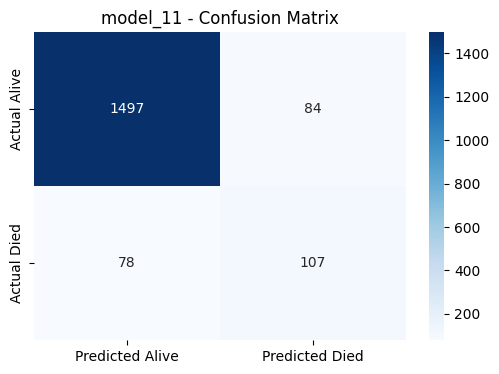


ROC-AUC Score: 0.8015


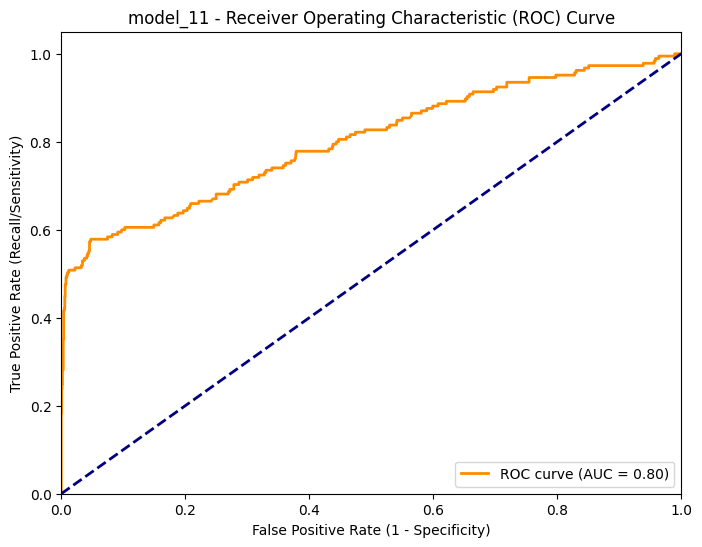

PR-AUC Score: 0.6114


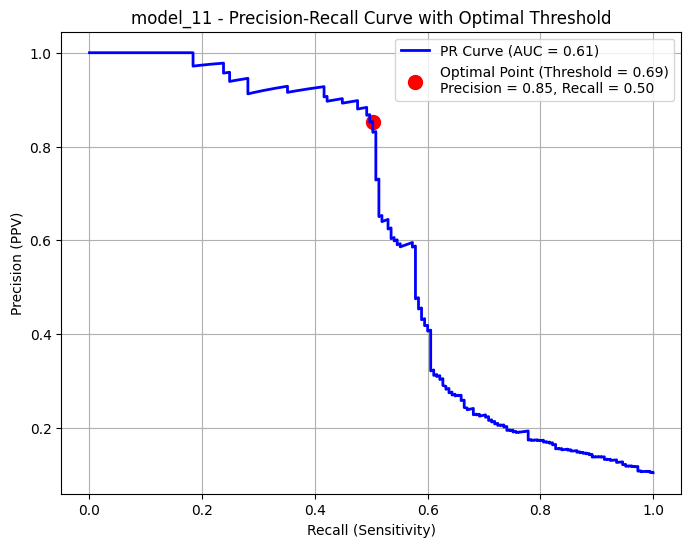


Classification Report at Optimal Threshold (0.69):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.97      1581
        Died       0.85      0.50      0.63       185

    accuracy                           0.94      1766
   macro avg       0.90      0.75      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1565   16]
 [  92   93]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9899


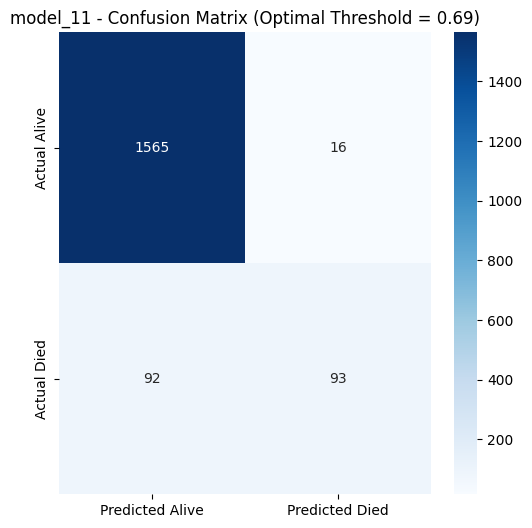

In [ ]:
evaluate_model_performance(y_test, y_hy_pred2, y_hy_proba2, model_name="model_11")

## HYBRID + GS

**Training**

In [ ]:
param_grid = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__max_depth': [3, 5],
    'xgbclassifier__learning_rate': [0.01, 0.05],
    'xgbclassifier__subsample': [0.8],
    'xgbclassifier__colsample_bytree': [0.8, 1.0],
    'xgbclassifier__reg_alpha': [0, 0.5],
    'xgbclassifier__reg_lambda': [1.0],
    'xgbclassifier__gamma': [0, 0.1],
    'smote__sampling_strategy': [0.5, 0.75]
}

In [ ]:

xgb_hy_gs = GridSearchCV(
    estimator=xgb_hy,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    verbose=2,
    n_jobs=1
)

In [ ]:
xgb_hy_gs.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] END smote__sampling_strategy=0.5, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=1.0, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END smote__sampling_strategy=0.5, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=1.0, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END smote__sampling_strategy=0.5, xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_alpha=0, xgbclassifier__reg_lambda=1.0, xgbclassifier__subsample=0.8; total time=   0.1s
[CV] END smote__sampling_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early...
                         'xgbclassifier__colsample_bytree': [0.8, 1.0],
                         'xgbclassifier__gamma': [0, 0.1],
                         'xgbclassifier__learning_rate': [0.01, 0.05],
                         'xgbclassifier__max_depth': [3, 5],
                         'xgbclassifier__n_estimators': [100, 200],
                         'xgbclassifier__reg_alpha': [0, 0.5],
                         'xgbclassifier__reg_lambda': [1.0],
                         'xgbclassifier__subsample': [0.8]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
             verbose=2)

In [ ]:
# Best model
print("\nBest Params:", xgb_hy_gs.best_params_)
print("Best CV F1 Score:", xgb_hy_gs.best_score_)


Best Params: {'smote__sampling_strategy': 0.5, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__subsample': 0.8}
Best CV F1 Score: 0.5662544398230672


In [ ]:
best_xgb_hy_gs= xgb_hy_gs.best_estimator_
best_xgb_hy_gs.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('randomundersampler', RandomUnderSampler(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Prediction**

In [ ]:

y_hy_pred3 = best_xgb_hy_gs.predict(X_test)
y_hy_proba3 = best_xgb_hy_gs.predict_proba(X_test)[:, 1]


**Evaluation**


==================== Evaluation for model_12 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.93      0.94      1581
    Died (1)       0.51      0.58      0.55       185

    accuracy                           0.90      1766
   macro avg       0.73      0.76      0.74      1766
weighted avg       0.90      0.90      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9349


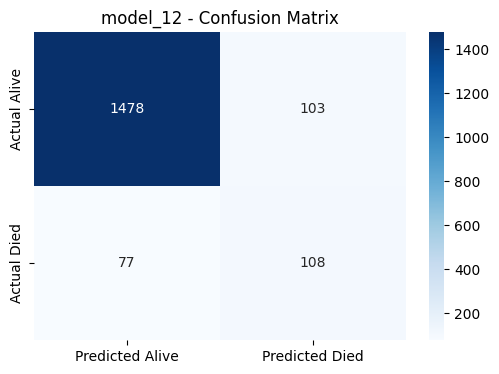


ROC-AUC Score: 0.8047


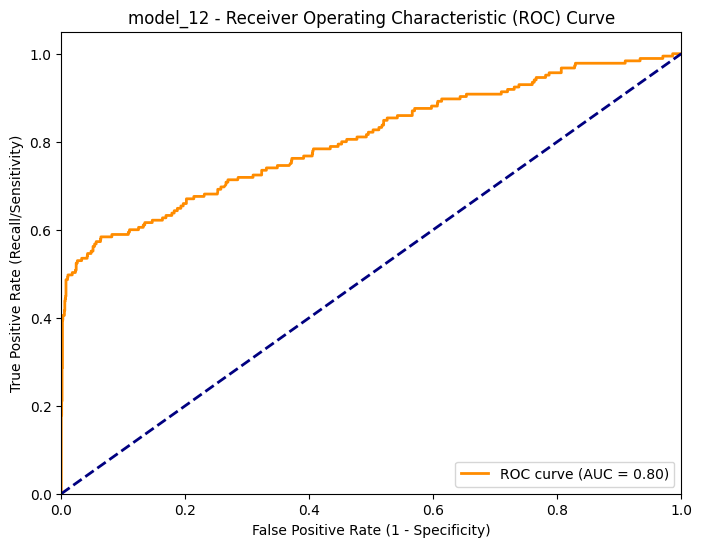

PR-AUC Score: 0.6146


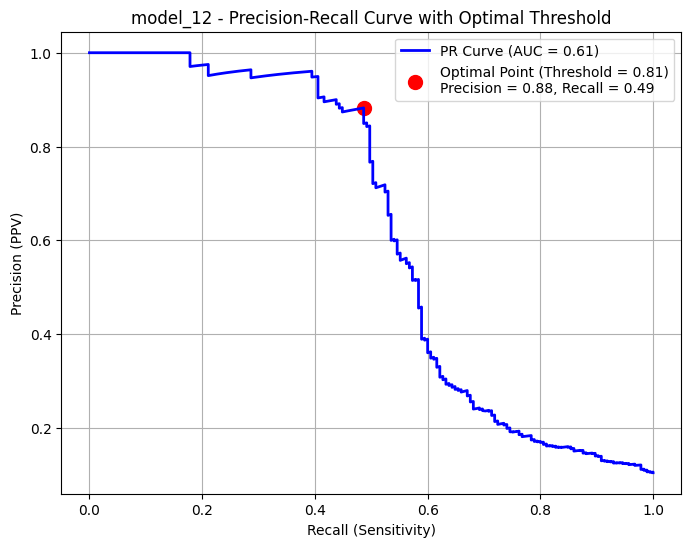


Classification Report at Optimal Threshold (0.81):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.97      1581
        Died       0.88      0.49      0.63       185

    accuracy                           0.94      1766
   macro avg       0.91      0.74      0.80      1766
weighted avg       0.94      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1569   12]
 [  95   90]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9924


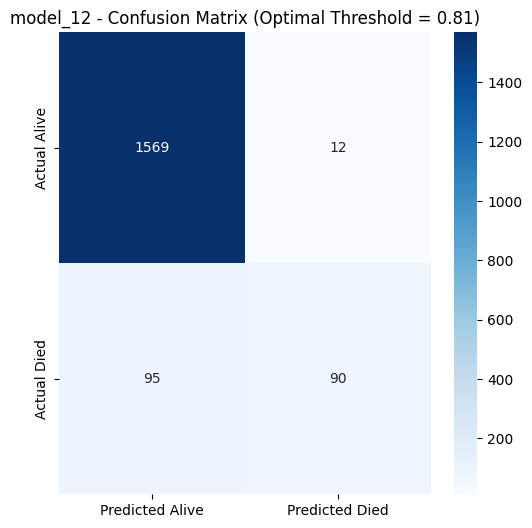

In [ ]:
evaluate_model_performance(y_test, y_hy_pred3, y_hy_proba3, model_name="model_12")

#Overfitting Assessment

Compute training and test accuracy to check for overfitting of the best model of XGB algorithem.

In [ ]:
# Predict on training data
y_o_train_pred = best_xgb_rs.predict(X_train)
train_accuracy = accuracy_score(y_train, y_o_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on test data
y_o_test_pred = best_xgb_rs.predict(X_test)
test_accuracy = accuracy_score(y_test, y_o_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare: If train >> test, potential overfitting
if train_accuracy - test_accuracy > 0.05:
    print("Warning: Model may be overfitting (large gap between train and test accuracy).")
else:
    print("Model appears well-generalized.")

Training Accuracy: 0.9548
Test Accuracy: 0.9434
Model appears well-generalized.
